In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import savemat
import math
import torchaudio

from loading_real_wave_noise import loading_real_wave_noise
from Reading_path_test import loading_paths_from_MAT
from Control_filter_selection import Control_filter_selection
from Fixed_filter_noise_cancellation_subfilters import Fixed_filter_controller
from Disturbance_generation import Disturbance_generation_from_real_noise
from FxLMS_algorithm import FxLMS, train_fxlms_algorithm

print(torch.cuda.is_available())

True


In [2]:
# real noises
mdict = {}
fs = 16000
StepSize = 0.0001
sound_name = 'Handheld drill'
waveform, resample_rate = loading_real_wave_noise(folde_name='Noise Examples/Real_noises', sound_name=sound_name+'.wav')

In [3]:
# Synthetic acoustic paths
#Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='SyntheticPath', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')

# Real acoustic paths
Pri_path, Secon_path = loading_paths_from_MAT(folder='Pz and Sz', subfolder='RealPath', Pri_path_file_name='Primary_path.mat', Sec_path_file_name='Secondary_path.mat')

Dis, Fx, Re = Disturbance_generation_from_real_noise(fs=fs, Repet=0, wave_form=waveform, Pri_path=Pri_path, Sec_path=Secon_path)
# Dis: disturbance (cotrolled noise)， Fx: fixed-x signal, Re: repeated waveform (primary_noise) Repetition=Repet+1

In [4]:
print(waveform.shape)
print(Dis.shape)
print(Fx.shape)
print(Re.shape)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

torch.Size([1, 160000])
torch.Size([160000])
torch.Size([160000])
torch.Size([160000])


The primary nosie has 10 seconds !!!
1 [0.99, 0.9, 1.0, 1.0, 0.29, 0.15, 0.39, 0.19, 0.25, 0.24, 0.29, 0.33, 0.27, 0.13, 0.07]
2 [1.0, 1.0, 1.0, 1.0, 0.39, 0.2, 0.48, 0.22, 0.17, 0.21, 0.36, 0.33, 0.19, 0.08, 0.03]
3 [1.0, 1.0, 1.0, 1.0, 0.61, 0.31, 0.5, 0.22, 0.22, 0.14, 0.19, 0.19, 0.06, 0.05, 0.02]
4 [1.0, 1.0, 1.0, 1.0, 0.32, 0.17, 0.52, 0.22, 0.3, 0.32, 0.5, 0.52, 0.41, 0.15, 0.08]
5 [1.0, 1.0, 1.0, 1.0, 0.34, 0.18, 0.63, 0.28, 0.32, 0.29, 0.37, 0.51, 0.42, 0.13, 0.15]
6 [1.0, 1.0, 1.0, 1.0, 0.28, 0.16, 0.58, 0.24, 0.37, 0.36, 0.45, 0.5, 0.4, 0.15, 0.22]
7 [1.0, 1.0, 1.0, 1.0, 0.23, 0.12, 0.41, 0.17, 0.21, 0.28, 0.39, 0.38, 0.27, 0.12, 0.09]
8 [1.0, 1.0, 1.0, 1.0, 0.66, 0.24, 0.36, 0.21, 0.23, 0.13, 0.15, 0.22, 0.08, 0.06, 0.03]
9 [1.0, 1.0, 1.0, 1.0, 0.79, 0.34, 0.46, 0.23, 0.2, 0.16, 0.26, 0.44, 0.11, 0.05, 0.02]
10 [1.0, 1.0, 1.0, 1.0, 0.7, 0.33, 0.47, 0.27, 0.21, 0.16, 0.27, 0.44, 0.09, 0.05, 0.02]


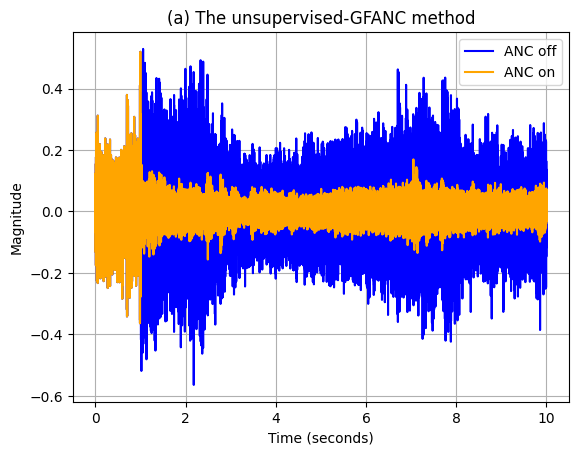

In [5]:
# Proposed Unsupervised-GFANC: the 1D CNN is trained using unsupervised learning
# Paper link: https://arxiv.org/pdf/2402.09460.pdf

MODEL_PTH = 'models/1DCNN_SyntheticDataset_UnsupervisedLearning.pth'
sub_filter_path = 'models/Pretrained_Sub_Control_filters_RealPath.mat'

# prediction index
Filter_vector = Control_filter_selection(fs=16000, MODEL_PTH=MODEL_PTH, path_mat=sub_filter_path, Primary_noise=Re.unsqueeze(0))

Fixed_Cancellation = Fixed_filter_controller(Filter_vector=Filter_vector, fs=16000)
ErrorFixed1 = Fixed_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx)

Time = np.arange(len(Dis))*(1/fs)

plt.title('(a) The unsupervised-GFANC method')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFixed1, color='orange', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.show()

The primary nosie has 10 seconds !!!
1 [0.88, 0.66, 0.58, 0.58, 0.49, 0.27, 0.22, 0.16, 0.12, 0.17, 0.11, 0.1, 0.11, 0.11, 0.12]
2 [0.94, 0.65, 0.5, 0.47, 0.4, 0.19, 0.17, 0.16, 0.1, 0.15, 0.11, 0.11, 0.14, 0.1, 0.12]
3 [0.96, 0.63, 0.47, 0.51, 0.44, 0.19, 0.18, 0.19, 0.11, 0.14, 0.09, 0.1, 0.12, 0.09, 0.1]
4 [0.91, 0.74, 0.59, 0.55, 0.55, 0.34, 0.26, 0.2, 0.16, 0.24, 0.16, 0.16, 0.21, 0.15, 0.17]
5 [0.98, 0.92, 0.7, 0.67, 0.63, 0.31, 0.24, 0.27, 0.18, 0.25, 0.17, 0.21, 0.38, 0.17, 0.16]
6 [0.98, 0.93, 0.74, 0.68, 0.63, 0.32, 0.23, 0.24, 0.19, 0.28, 0.17, 0.19, 0.32, 0.14, 0.15]
7 [0.92, 0.74, 0.63, 0.59, 0.54, 0.25, 0.19, 0.17, 0.13, 0.19, 0.13, 0.14, 0.16, 0.11, 0.12]
8 [0.96, 0.66, 0.53, 0.64, 0.44, 0.17, 0.15, 0.17, 0.09, 0.12, 0.08, 0.09, 0.09, 0.09, 0.1]
9 [0.96, 0.7, 0.53, 0.58, 0.5, 0.19, 0.2, 0.3, 0.13, 0.17, 0.12, 0.09, 0.13, 0.12, 0.15]
10 [0.96, 0.62, 0.44, 0.51, 0.42, 0.13, 0.15, 0.27, 0.11, 0.16, 0.11, 0.08, 0.13, 0.11, 0.14]


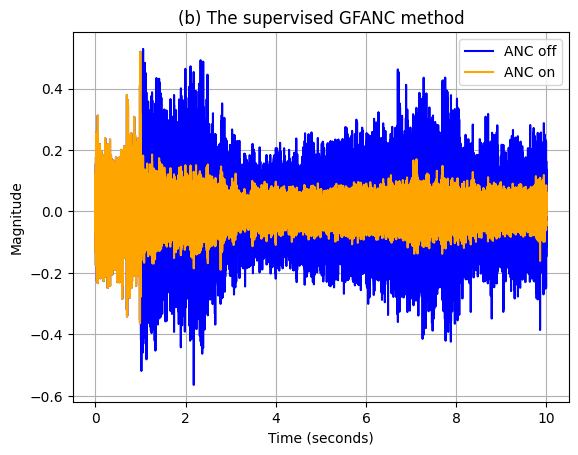

In [6]:
# Supervised-GFANC: the 1D CNN is trained using supervised learning
# Paper (GFANC soft weights no Bayes): https://www.researchgate.net/publication/376227144_Delayless_Generative_Fixed-filter_Active_Noise_Control_based_on_Deep_Learning_and_Bayesian_Filter

MODEL_PTH = 'models/1DCNN_SyntheticDataset_SupervisedLearning.pth'
sub_filter_path = 'models/Pretrained_Sub_Control_filters_RealPath.mat'

# prediction index
Filter_vector = Control_filter_selection(fs=16000, MODEL_PTH=MODEL_PTH, path_mat=sub_filter_path, Primary_noise=Re.unsqueeze(0))

Fixed_Cancellation = Fixed_filter_controller(Filter_vector=Filter_vector, fs=16000)
ErrorFixed2 = Fixed_Cancellation.noise_cancellation(Dis=Dis, Fx=Fx)

Time = np.arange(len(Dis))*(1/fs)

plt.title('(b) The supervised GFANC method')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFixed2, color='orange', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.show()

[========================================================================] 100%


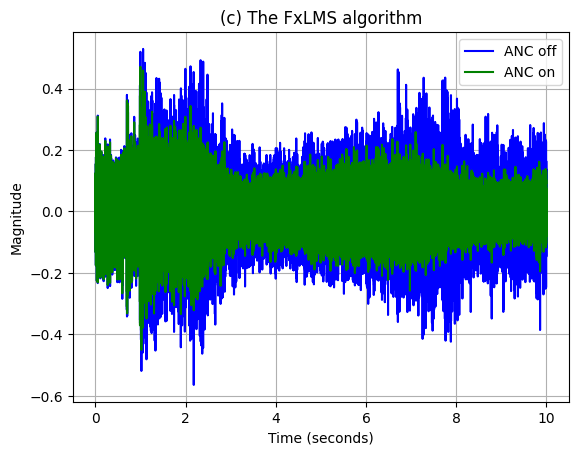

In [7]:
# FxLMS

controller = FxLMS(Len=1024) # 1024 is the same size of coeffient vector of fixed-filter
ErrorFxLMS = train_fxlms_algorithm(Model=controller, Ref=Fx, Disturbance=Dis, Stepsize=StepSize) # torch.Size([320000])

Time = np.arange(len(Dis))*(1/fs)

plt.title('(c) The FxLMS algorithm')
plt.plot(Time, Dis, color='blue', label='ANC off')
plt.plot(Time, ErrorFxLMS, color='green', label='ANC on')
plt.ylabel('Magnitude')
plt.xlabel('Time (seconds)')
plt.legend()
plt.grid()
plt.show()

In [8]:
if torch.is_tensor(Dis):
    Dis = Dis.numpy() # tensor to numpy
if torch.is_tensor(ErrorFixed1):
    ErrorFixed1 = ErrorFixed1.numpy()
if torch.is_tensor(ErrorFixed2):
    ErrorFixed2 = ErrorFixed2.numpy()
ErrorFxLMS = np.array(ErrorFxLMS)

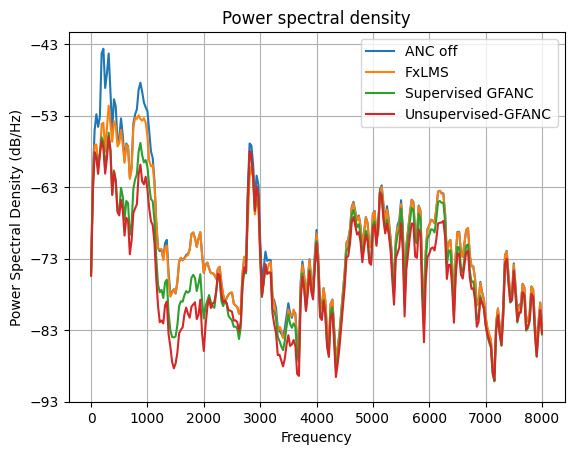

In [9]:
# Power spectral density

plt.title('Power spectral density')
plt.psd(Dis, Fs=fs, NFFT=512)
plt.psd(ErrorFxLMS, Fs=fs, NFFT=512)
plt.psd(ErrorFixed2, Fs=fs, NFFT=512)
plt.psd(ErrorFixed1, Fs=fs, NFFT=512)
plt.legend(['ANC off', 'FxLMS', 'Supervised GFANC', 'Unsupervised-GFANC'])
plt.show()

In [10]:
# Normalized mean squared error (NMSE)

def compute_NMSE(Error, Disturbance):
    # Calculate the NMSE
    nmse = 10 * np.log10(np.sum(Error**2) / np.sum(Disturbance**2))
    return nmse
    
print(compute_NMSE(ErrorFixed1, Dis))
print(compute_NMSE(ErrorFixed2, Dis))
print(compute_NMSE(ErrorFxLMS, Dis))

-9.049251675605774
-7.977270483970642
-4.325181984124478


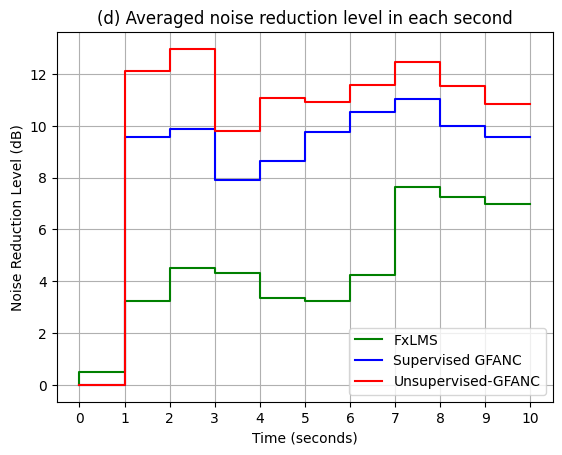

In [11]:
# Compare the Noise_Reduction_Level in every second

def Noise_Reduction_Level_Compute(Disturbance, Error):
    Power_dis = 10*np.log10(np.var(Disturbance))
    Power_err = 10*np.log10(np.var(Error))
    NR_level = Power_dis - Power_err
    return NR_level


a, b, c = [], [], []
a.append(Dis[0])
b.append(Dis[0])
c.append(Dis[0])
Time1 = int(len(Dis)/fs)
for t in range(Time1):
    a.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorFixed1[t*fs:(t+1)*fs]))
    b.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorFixed2[t*fs:(t+1)*fs]))
    c.append(Noise_Reduction_Level_Compute(Dis[t*fs:(t+1)*fs], ErrorFxLMS[t*fs:(t+1)*fs]))
    
plt.title('(d) Averaged noise reduction level in each second')
plt.step(range(0,Time1+1), c, color='green', label='FxLMS')
plt.step(range(0,Time1+1), b, color='blue', label='Supervised GFANC')
plt.step(range(0,Time1+1), a, color='red', label='Unsupervised-GFANC')
plt.ylabel('Noise Reduction Level (dB)')
plt.xlabel('Time (seconds)')
plt.xticks(range(0, Time1+1, 1))
plt.legend()
plt.grid()
plt.show()